# Menelaus - DataDrift

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import menelaus
from matplotlib import gridspec
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from menelaus.datasets import make_example_batch_data
from menelaus.datasets import fetch_circle_data
from menelaus.data_drift.cdbd import CDBD
from menelaus.data_drift.hdddm import HDDDM
from menelaus.data_drift import KdqTreeStreaming, KdqTreeBatch

# Dataset Creation

In [2]:
df = make_example_batch_data()

In [3]:
df

,year,a,b,c,d,e,f,g,h,i,j,cat,confidence,drift
0,2007,5036.441154,198.936685,6995.029198,133187.697950,0.402750,-1.339692,90453.457231,8819.761759,5398.861764,1059.835492,2,0.591243,False
1,2007,10773.027107,179.260652,3467.970499,52174.100900,1.019491,-1.145258,72629.507052,10137.233887,7009.344647,1552.888540,2,0.196090,False
2,2007,6173.596856,199.775829,4921.472906,101848.950792,-2.248839,1.903668,54839.516587,9603.709193,10579.518133,856.266082,1,0.504019,False
3,2007,13208.612929,182.222072,9638.632797,92442.165726,-0.045599,1.106212,84447.758390,12511.305427,5618.433039,451.926312,2,0.487307,False
4,2007,2719.272009,213.028454,5501.439179,79155.846985,-1.602719,-1.368130,168769.099013,16034.259622,6214.909756,853.582074,1,0.211284,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,2021,8434.682418,203.931217,8674.083920,104317.953759,-1.588765,-1.313684,165132.657078,284.979440,7065.994173,83.803525,2,0.641595,True
299996,2021,9701.660570,179.925659,8021.128673,63749.091322,0.412063,0.408188,124630.300901,323.602163,10960.392248,96.796410,1,0.467875,True
299997,2021,6928.908424,210.007943,3312.751778,126116.364855,0.113971,2.432577,107318.127090,214.452933,9491.057615,169.644626,2,0.787726,True
299998,2021,6410.255420,205.092167,6914.861179,158221.742954,0.060710,0.928108,71610.603448,570.911317,8577.498702,61.404365,0,0.689538,True


This function returns a dataframe containing synthetic batch data for use with the repo’s examples. The dataframe’s columns are "year", "a", "b", ... "j", "cat", "confidence", "drift".

- year covers 2007-2021, with 20,000 observations each.

- Features "b", "e", "f" are normally distributed.

- Features "a", "c", "d", "g", "h", "i", "j" have a gamma distribution.

- The "cat" feature contains categorical variables ranging from 1-7, sampled with varying probability.

- "confidence" contains values on [0, 0.6] through 2018, then values on [0.4, 1].

Drift occurs as follows:

- Change the mean of column "b" in 2009. Reverts to original distribution in 2010.

- Change the variance of columns "c" and "d" in 2012 by replacing some samples with the mean. Reverts to original distribution in 2013.

- Increase the correlation of columns "e" and "f" in 2015 (0 correlation to 0.5 correlation).

- Change the mean and variance of column "h" in 2019, and maintain this new distribution going forward. Change the range of the “confidence” column going forward.

- Change the mean and variance of column "j" in 2021.



## Confidence Distribution Batch Detection (CDBD)

In [4]:
# Set up reference and test batches, using 2007 as reference year
reference = pd.DataFrame(df[df.year == 2007].loc[:, "confidence"])
analysis = df[df.year != 2007]

In [5]:
reference

,confidence
0,0.591243
1,0.196090
2,0.504019
3,0.487307
4,0.211284
...,...
19995,0.455138
19996,0.551015
19997,0.112861
19998,0.256144


In [6]:
# Run CDBD
cdbd = CDBD(subsets=8)
cdbd.set_reference(reference)

In [7]:
# Store drift for test statistic plot
detected_drift = []
for year, subset_data in analysis.groupby("year"):
    cdbd.update(pd.DataFrame(subset_data.loc[:, "confidence"])) #We update the model for each year
    detected_drift.append(cdbd.drift_state)

In [8]:
for year, group_data in analysis.groupby("year"):
    print(year)
    print(group_data)


2008
       year            a           b             c              d         e  \
20000  2008  8649.584011  207.602830   9687.120486  143791.345016  0.401621   
20001  2008  7264.898855  192.769976   8860.251514   97848.696655 -0.167604   
20002  2008  4545.060147  184.549194   4806.049840  112462.606747 -1.918609   
20003  2008  5513.775274  216.922725   6169.812037  160187.667567  0.427451   
20004  2008  6019.929532  214.542831   7739.660346   47545.023914 -1.441836   
...     ...          ...         ...           ...            ...       ...   
39995  2008  6095.816852  199.105642   7837.636350   76399.638226 -1.152090   
39996  2008  6085.073395  205.435214   7312.651063  120872.603878  0.972084   
39997  2008  6255.778884  175.922237   5435.020871  118487.121137  0.913788   
39998  2008  9277.189113  218.824359   7616.122925  117410.732375  2.429926   
39999  2008  9633.912832  192.185719  10018.634213   99130.994161  1.050172   

              f              g             h  

In [9]:
pd.DataFrame(subset_data.loc[:, "confidence"])

,confidence
280000,0.790394
280001,0.584123
280002,0.449264
280003,0.525931
280004,0.786005
...,...
299995,0.641595
299996,0.467875
299997,0.787726
299998,0.689538


In [10]:
detected_drift

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 'drift',
 None,
 None,
 None,
 'drift',
 None,
 None]

In [11]:
# Calculate divergences for all years in dataset
years = list(df.year.value_counts().index[1:])

In [12]:
kl_divergence = [
    ep - th for ep, th in zip(cdbd.epsilon_values.values(), cdbd.thresholds.values())
]


In [13]:
# Remove potential infs that arise because of small confidence scores
kl_divergence = [
    x if np.isnan(x) == False and np.isinf(x) == False else 0 for x in kl_divergence
]

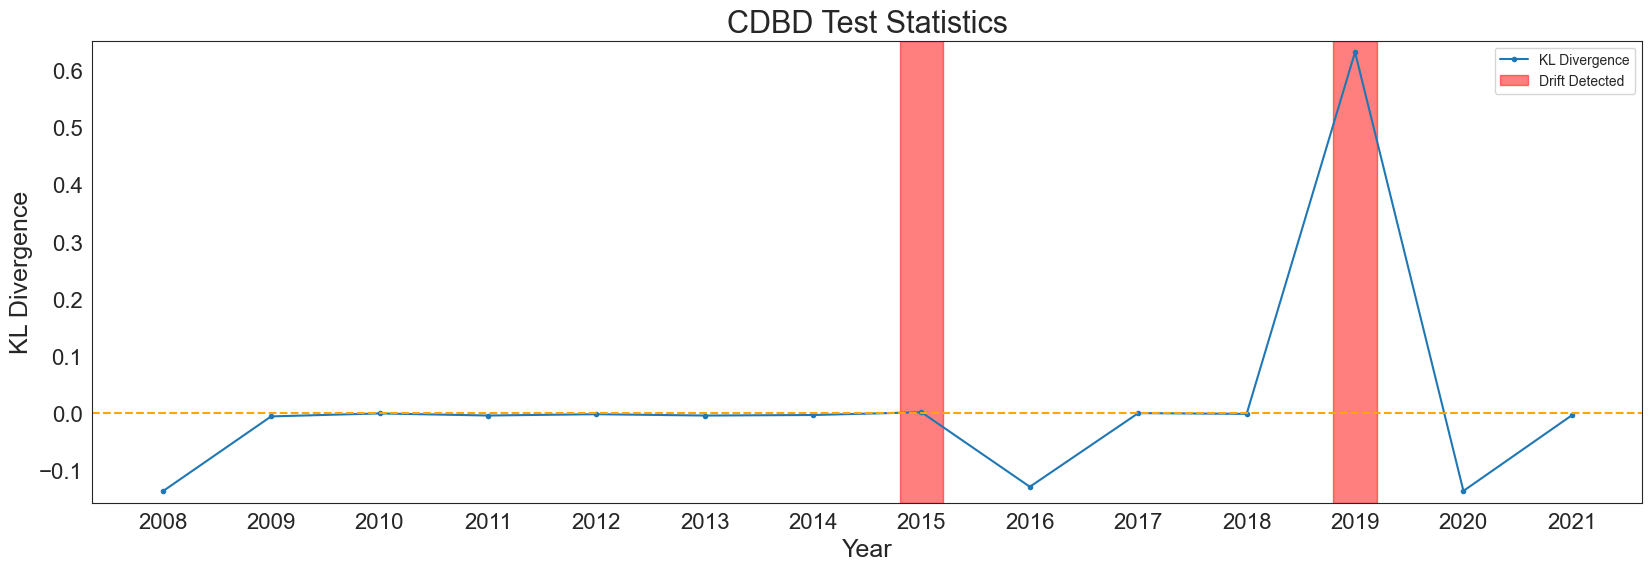

In [14]:
# Plot KL Divergence against Year, along with detected drift
plot_data = pd.DataFrame(
    {"Year": years, "KL Divergence": kl_divergence, "Detected Drift": detected_drift}
)
sns.set_style("white")
plt.figure(figsize=(20, 6))
plt.plot("Year", "KL Divergence", data=plot_data, label="KL Divergence", marker=".")
plt.grid(False, axis="x")

plt.xticks(years, fontsize=16)
plt.yticks(fontsize=16)
plt.title("CDBD Test Statistics", fontsize=22)
plt.ylabel("KL Divergence", fontsize=18)
plt.xlabel("Year", fontsize=18)
plt.ylim([min(kl_divergence) - 0.02, max(kl_divergence) + 0.02])


for _, t in enumerate(plot_data.loc[plot_data["Detected Drift"] == "drift"]["Year"]):
    plt.axvspan(
        t - 0.2, t + 0.2, alpha=0.5, color="red", label=("Drift Detected" if _ == 0 else None)
    )

plt.legend()
plt.axhline(y=0, color="orange", linestyle="dashed")
plt.show()

## Hellinger Distance Drift Detection Method (HDDDM)

In [15]:
# Set up reference and test batches, using 2007 as reference year
# -2 indexing removes columns "drift" and "confidence"
reference = df[df.year == 2007].iloc[:, 1:-2]
analysis = df[df.year != 2007]

In [16]:
reference

,a,b,c,d,e,f,g,h,i,j,cat
0,5036.441154,198.936685,6995.029198,133187.697950,0.402750,-1.339692,90453.457231,8819.761759,5398.861764,1059.835492,2
1,10773.027107,179.260652,3467.970499,52174.100900,1.019491,-1.145258,72629.507052,10137.233887,7009.344647,1552.888540,2
2,6173.596856,199.775829,4921.472906,101848.950792,-2.248839,1.903668,54839.516587,9603.709193,10579.518133,856.266082,1
3,13208.612929,182.222072,9638.632797,92442.165726,-0.045599,1.106212,84447.758390,12511.305427,5618.433039,451.926312,2
4,2719.272009,213.028454,5501.439179,79155.846985,-1.602719,-1.368130,168769.099013,16034.259622,6214.909756,853.582074,1
...,...,...,...,...,...,...,...,...,...,...,...
19995,5364.710821,208.382360,9746.552079,101526.208163,-0.698032,-0.881142,70916.529162,14062.450341,10971.969397,917.322988,2
19996,4483.465573,203.131806,6480.968712,139829.904270,0.027155,1.659847,100089.773534,9693.803736,12887.003253,1243.383758,0
19997,5422.838534,201.958562,17409.525027,81433.431760,-2.001971,1.796530,88055.279116,23136.862696,9352.747232,1294.432068,3
19998,13140.759011,192.956187,3374.866352,80084.265655,-1.575061,-0.347297,132191.130413,10319.941080,11238.232369,842.221964,1


In [17]:
np.random.seed(1)
hdddm = HDDDM(subsets=8)

In [18]:
# Store epsilons per feature for heatmap
years = analysis.year.unique()
heatmap_data = pd.DataFrame(columns = years)

In [19]:
# Store drift for test statistic plot
detected_drift = []

In [27]:
# Run HDDDM
hdddm.set_reference(reference)
for year, subset_data in df[df.year != 2007].groupby("year"):
    print(year)
    print(subset_data.iloc[:,1:-2])
    
    hdddm.update(subset_data.iloc[:, 1:-2])
    heatmap_data[year] = hdddm.feature_epsilons
    detected_drift.append(hdddm.drift_state)

2008
                 a           b             c              d         e  \
20000  8649.584011  207.602830   9687.120486  143791.345016  0.401621   
20001  7264.898855  192.769976   8860.251514   97848.696655 -0.167604   
20002  4545.060147  184.549194   4806.049840  112462.606747 -1.918609   
20003  5513.775274  216.922725   6169.812037  160187.667567  0.427451   
20004  6019.929532  214.542831   7739.660346   47545.023914 -1.441836   
...            ...         ...           ...            ...       ...   
39995  6095.816852  199.105642   7837.636350   76399.638226 -1.152090   
39996  6085.073395  205.435214   7312.651063  120872.603878  0.972084   
39997  6255.778884  175.922237   5435.020871  118487.121137  0.913788   
39998  9277.189113  218.824359   7616.122925  117410.732375  2.429926   
39999  9633.912832  192.185719  10018.634213   99130.994161  1.050172   

              f              g             h             i            j  cat  
20000 -2.786686   68455.676084   9801.7

In [21]:
detected_drift

[None,
 'drift',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 'drift',
 None,
 'drift']

In [22]:
## Plot Line Graph ##
h_distances = [
    ep - th for ep, th in zip(hdddm.epsilon_values.values(), hdddm.thresholds.values())
]

In [23]:
# Plot Hellinger Distance against Year, along with detected drift
plot_data = pd.DataFrame(
    {"Year": years, "Hellinger Distance": h_distances, "Detected Drift": detected_drift}
)

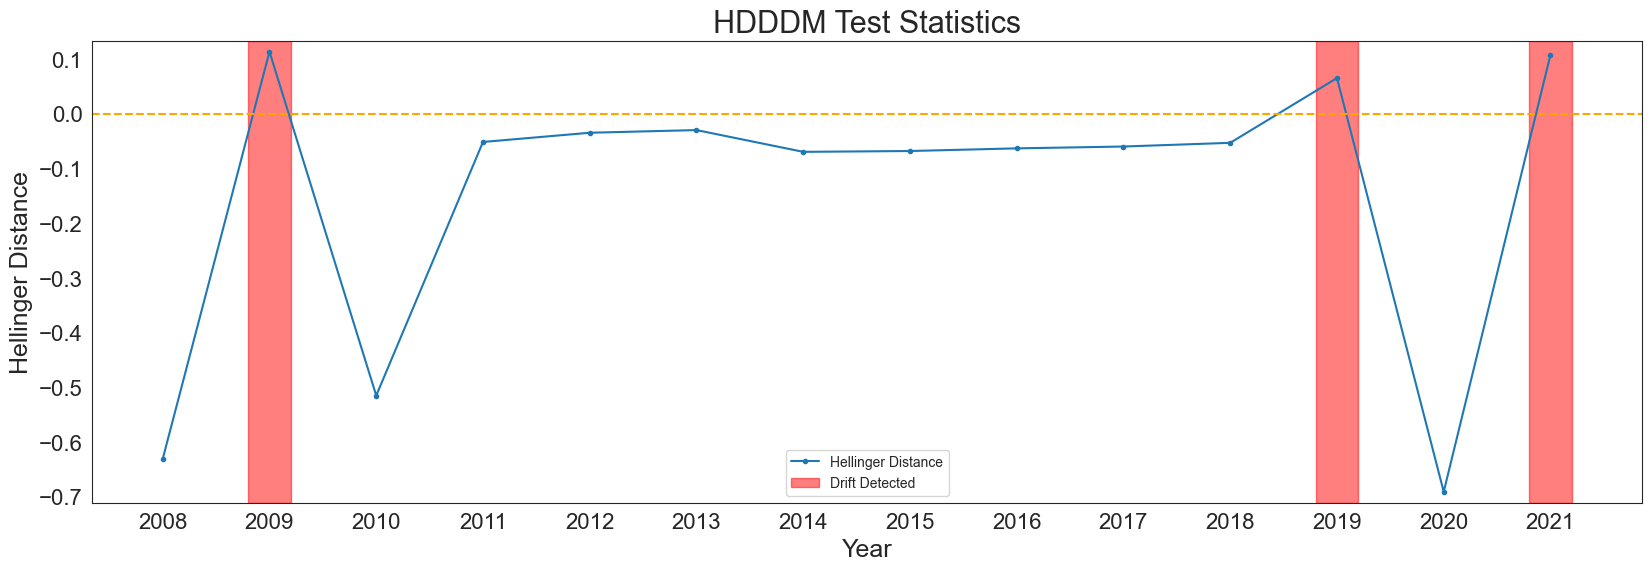

In [24]:
sns.set_style("white")
plt.figure(figsize=(20, 6))
plt.plot(
    "Year", "Hellinger Distance", data=plot_data, label="Hellinger Distance", marker="."
)
plt.grid(False, axis="x")
plt.xticks(years, fontsize=16)
plt.yticks(fontsize=16)
plt.title("HDDDM Test Statistics", fontsize=22)
plt.ylabel("Hellinger Distance", fontsize=18)
plt.xlabel("Year", fontsize=18)
plt.ylim([min(h_distances) - 0.02, max(h_distances) + 0.02])
for _, t in enumerate(plot_data.loc[plot_data["Detected Drift"] == "drift"]["Year"]):
    plt.axvspan(
        t - 0.2, t + 0.2, alpha=0.5, color="red", label=("Drift Detected" if _ == 0 else None)
    )
plt.legend()
plt.axhline(y=0, color="orange", linestyle="dashed")

plt.show()

HDDDM identifies drifts in 2009, 2010, 2012, 2019, 2021. These drifts involve a change in mean or variance. Drift in 2010 is likely identified as the distribution returns to state prior to 2009 drift. Drift in 2015, a change in correlation, is undetected. Drift in 2018 is detected one year late.

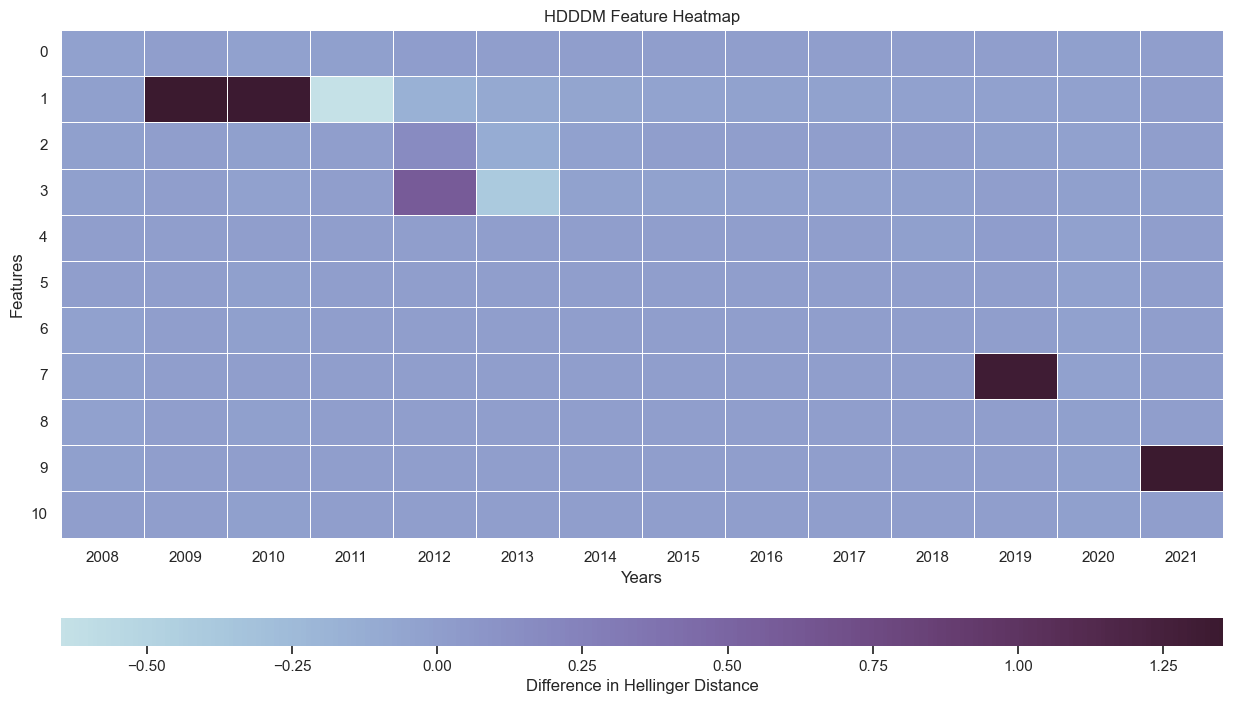

In [25]:
## Plot Heatmap ##
sns.set_style("whitegrid")
sns.set(rc={"figure.figsize": (15, 8)})

# Setup plot

# Setup plot
grid_kws = {"height_ratios": (0.9, 0.05), "hspace": 0.3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
coloring = sns.cubehelix_palette(start=0.8, rot=-0.5, as_cmap=True)
ax = sns.heatmap(
    heatmap_data,
    ax=ax,
    cmap=coloring,
    xticklabels=heatmap_data.columns,
    yticklabels=heatmap_data.index,
    linewidths=0.5,
    cbar_ax=cbar_ax,
    cbar_kws={"orientation": "horizontal"},
)
ax.set_title('HDDDM Feature Heatmap')
ax.set(xlabel="Years", ylabel="Features")
ax.collections[0].colorbar.set_label("Difference in Hellinger Distance")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.show()

### Results

- Drift in feature B is detected in 2009 and 2010 (as it reverts to normal).
- Drift in feature D is detected in 2012 and 2013 (as it reverts to normal).
- Drift in feature H is detected in 2019. Drift in feature J is detected in 2021.
- The undetected drift occurs in 2015 in the correlations between features E and F.
